# Imports

In [16]:
#for loading the dataset
import xml.etree.ElementTree as ET
import pandas as pd
import os

#for plotting
import matplotlib.pyplot as plt

#for text processing
import nltk

#for saving the preprocessed dataset
import pickle

# Loading Dataset

Our starting point is a collection of XML files collected in [this paper by David E. Losada et al.](https://tec.citius.usc.es/ir/pdf/CLEF16_paper.pdf). Each XML stores a sequence of submissions, including date, text and title.

In [2]:
def xml2dataframe(file_path):
  """
  Takes a xml (one per subject) file and returns a 
  dataframe with 1 column:
  |-------------------------- |
  | TEXT                      |
  |---------------------------|
  |"All posts from subject 0" |
  |---------------------------|
  |"All posts from subject 1" |
  |---------------------------|
  ....

  """
  tree = ET.parse(file_path)
  root = tree.getroot()
  all_posts = []

  for i in root.iter("WRITING"): #Iterate over the "WRITING" elements
    post = i.find("TEXT").text #Get the "TEXT" parts (these contain the posts)
    all_posts.append(post) #get a list of all posts, each one is a string

  one_post = " ".join(all_posts) #join all posts into a single string
  one_post_list = [] #we need the one_post string to be a list
  one_post_list.append(one_post)

  #create a dataframe with all the posts (one post per row)
  df = pd.DataFrame(one_post_list, columns=["TEXT"]) 
  return df

In [5]:
def create_test_df():

	"""loads the positive and negative subjects from the 
	test data"""

	test_neg_folder = "filepath"
	test_pos_folder = "filepath"

	test_positive_dfs, test_negative_dfs = [], []


	for file in os.listdir(test_pos_folder): 
		filename = test_pos_folder + "/" + os.fsdecode(file)
		test_pos_df = xml2dataframe(filename)
		test_positive_dfs.append(test_pos_df)

	test_pos_big_df = pd.concat(test_positive_dfs)
	test_pos_big_df["LABEL"] = 1 #add 1 for "depressed" subjects in the positive folder

	for file in os.listdir(test_neg_folder): 
		filename = test_neg_folder + "/" + os.fsdecode(file)
		test_neg_df = xml2dataframe(filename)
		test_negative_dfs.append(test_neg_df)

	test_neg_big_df = pd.concat(test_negative_dfs)
	test_neg_big_df["LABEL"] = 0 #add 0 for "non-depressed" subjects in the negative folder

	test_df = test_pos_big_df.append(test_neg_big_df)
	return test_df

In [6]:
def create_training_df():
	"""loads the positive and negative subjects from the 
	training data"""
	
	train_neg_folder = "filepath"
	train_pos_folder = "filepath"

	train_positive_dfs, train_negative_dfs = [], []


	for file in os.listdir(train_pos_folder): 
		filename = train_pos_folder + "/" + os.fsdecode(file)
		train_pos_df = xml2dataframe(filename)
		train_positive_dfs.append(train_pos_df)

	train_pos_big_df = pd.concat(train_positive_dfs)
	train_pos_big_df["LABEL"] = 1 

	for file in os.listdir(train_neg_folder): 
		filename = train_neg_folder + "/" + os.fsdecode(file)
		train_neg_df = xml2dataframe(filename)
		train_negative_dfs.append(train_neg_df)

	train_neg_big_df = pd.concat(train_negative_dfs)
	train_neg_big_df["LABEL"] = 0

	training_df = train_pos_big_df.append(train_neg_big_df)
	return training_df

In [7]:
test_df = create_test_df()
training_df = create_training_df()

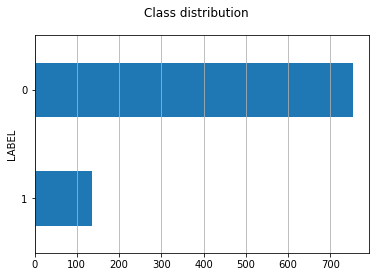

In [11]:
#check composition of the dataset
df_comp = pd.concat([training_df, test_df]) 

fig, ax = plt.subplots()
fig.suptitle("Class distribution", fontsize=12)
df_comp["LABEL"].reset_index().groupby("LABEL").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The dataset is very umbalanced, which might create some problems in our model later

# Preprocessing

In [13]:
class TextPreprocessor:
  def __init__(self):
    nltk_resources = ["punkt", "averaged_perceptron_tagger", "wordnet", "stopwords", "words"]
    #check if resource is downloaded, if not, download it
    for resource in nltk_resources:
      try:
        nltk.data.find(resource)
      except LookupError:
        nltk.download(resource)

    self.lemmatizer = nltk.WordNetLemmatizer()
    self.words = set(nltk.corpus.words.words())
    self.stopwords = set(nltk.corpus.stopwords.words())

  def nltk_tag_to_wordnet_tag(self, nltk_tag):
    """Changes the nltk pos tags to wordnet tags to be tagged correctly
    in POS tagging
    """
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

  def lemmatize_text(self, text):
    """Lemmatizes the POS_tagged input text"""

    wordnet_tagged = map(lambda x: (x[0], self.nltk_tag_to_wordnet_tag(x[1])), text) #changes the tags to wordnet
    lemmatized = []
    for word, tag in wordnet_tagged:
        if tag is None:
          #if there is no available tag, append the token as is
          lemmatized.append(word)
        #expand common contractions
        elif word in ["'m", "'s", "'re", " 'm", " 's", " 're"]: 
          lemmatized.append("be")
        elif word == "'ve":
          lemmatized.append("have")
        elif word == "n't":
          lemmatized.append("not")
        else:
          #else use the tag to lemmatize the token
          lemmatized.append(self.lemmatizer.lemmatize(word, tag))

    return lemmatized

  def preprocessing(self, dataframe):
    """
    Takes a dataframe as input and preprocesses the data as follows:
      1. Tokenization
      2. Part of Speech Tagging
      3. Lemmatization
      4. Removes punctuation
      5. Removes non-words and lowecases all words
      6. Convert to string
    """
    # 1. Tokenization
    dataframe["TOKENIZED_TEXT"] = dataframe.apply(lambda row: nltk.word_tokenize(row['TEXT']), axis=1)

    # 2. POS Tagging
    dataframe["POS_TAGGED_TEXT"] = nltk.pos_tag_sents(dataframe["TOKENIZED_TEXT"])

    # 3. Lemmatization
    dataframe['LEMMATIZED_TEXT'] = dataframe['POS_TAGGED_TEXT'].apply(lambda row: self.lemmatize_text(row))

    #4. Remove punctuation
    dataframe["LEMMATIZED_TEXT"] = dataframe.apply(
        lambda row: [word for word in row["LEMMATIZED_TEXT"] if word.isalpha()], axis=1)

    #5. Non-word and stop word removal + lowercasing
    dataframe["FINAL_TEXT"] = dataframe.apply(
        lambda row: [w.lower() for w in row["LEMMATIZED_TEXT"] if w in self.words and w not in self.stopwords], 
        axis=1)

    #6. Convert to string
    dataframe['FINAL_TEXT_STRING'] = [' '.join(map(str, l)) for l in dataframe['FINAL_TEXT']]

    return dataframe

In [14]:
final_training_df = TextPreprocessor().preprocessing(training_df)
final_test_df = TextPreprocessor().preprocessing(test_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raulm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package

In [18]:
#save datasets as pickle objects

final_training_df.to_pickle("filepath")
final_test_df.to_pickle("filepath")